In [1]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
import numpy as np

import requests
import zipfile
from pathlib import Path

import pandas as pd

In [2]:
import os
# The jupyter notebook is launched from your $HOME directory.
# Change the working directory to the workshop directory
# which was created in your username directory under /scratch/vp91
os.chdir(os.path.expandvars("/scratch/vp91/$USER/"))

PyTorch offers two data primitives—`torch.utils.data.DataLoader` and `torch.utils.data.Dataset`— which 
facilitate the use of both pre-loaded datasets and custom data.

The `Fashion-MNIST` dataset is an example of a pre-loaded curated dataset. It can be loaded using the following parameters:

- `root` specifies the path where the training or test data is stored.
- `train` indicates whether to load the training or test dataset.
- `download=True` will download the data from the internet if it's not available at the specified `root`.
- `transform` and `target_transform` define the transformations applied to the features and labels, respectively.



In [3]:
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

In [5]:
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

In [6]:
!ls data/FashionMNIST/raw/

t10k-images-idx3-ubyte	   train-images-idx3-ubyte
t10k-images-idx3-ubyte.gz  train-images-idx3-ubyte.gz
t10k-labels-idx1-ubyte	   train-labels-idx1-ubyte
t10k-labels-idx1-ubyte.gz  train-labels-idx1-ubyte.gz


#### Visualizing a sample of the dataset

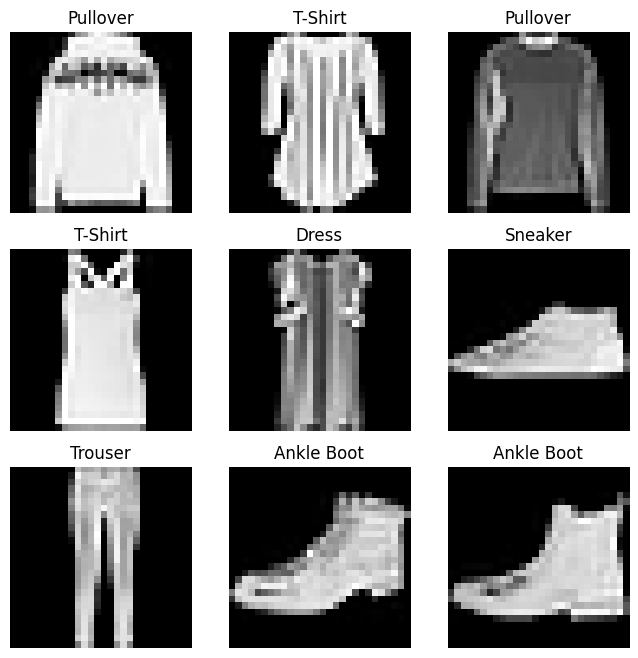

In [7]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

### Custom dataset

What if working with a custom dataset? To illustrate this, we will download a dataset and set it up for
use in PyTorch training. The data used for this demonstration is relatively *clean*. In a practical use case, significant time will likely be spent on cleaning and preparing the data.

The data:

1. There are **3 classes**: pizza, steak, and sushi.
2. The data is split into *train* and *test* datasets.
3. Both *train* and *test* datasets are further organized into 3 directories, each corresponding to one of the classes.

In [8]:
import requests
import zipfile
from pathlib import Path

# Setup path to data folder
data_root = Path("custom_data/")
image_path = data_root / "pizza_steak_sushi"

# If the image data doesn't exist, download it and curate it. 
if not image_path.is_dir():
    image_path.mkdir(parents=True, exist_ok=True)
    
    # Download pizza, steak, sushi data
    url = "https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip"
    with open(data_root / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get(url)
        f.write(request.content)

    with zipfile.ZipFile(data_root / "pizza_steak_sushi.zip", "r") as zip_ref:
        zip_ref.extractall(image_path)

In [9]:
!ls custom_data

pizza_steak_sushi  pizza_steak_sushi.zip


In [10]:
!ls custom_data/pizza_steak_sushi

test  train


In [11]:
!ls custom_data/pizza_steak_sushi/train

pizza  steak  sushi


In [12]:
!ls custom_data/pizza_steak_sushi/test

pizza  steak  sushi


In [14]:
!ls custom_data/pizza_steak_sushi/train/sushi

1070104.jpg  1552504.jpg  2021381.jpg  2720223.jpg  3360207.jpg  700405.jpg
1129338.jpg  1571146.jpg  2021685.jpg  2797464.jpg  3360232.jpg  710379.jpg
1138695.jpg  1575445.jpg  2120573.jpg  2813454.jpg  3426958.jpg  748830.jpg
1209865.jpg  1615453.jpg  2175561.jpg  2871052.jpg  3579071.jpg  765684.jpg
1214108.jpg  169392.jpg   2267190.jpg  2873571.jpg  3737197.jpg  773725.jpg
121940.jpg   170385.jpg   2323548.jpg  2980779.jpg  377047.jpg	 794647.jpg
1221830.jpg  17704.jpg	  2492146.jpg  3004029.jpg  385154.jpg	 821108.jpg
1232045.jpg  1957449.jpg  2574453.jpg  307738.jpg   390178.jpg	 840444.jpg
1280119.jpg  200025.jpg   2590819.jpg  3081701.jpg  424994.jpg	 843815.jpg
14046.jpg    2004525.jpg  2641778.jpg  3107839.jpg  497686.jpg	 855721.jpg
148799.jpg   2017378.jpg  2674024.jpg  3251688.jpg  542188.jpg	 929471.jpg
1551817.jpg  2019344.jpg  268990.jpg   3353428.jpg  686426.jpg	 93139.jpg


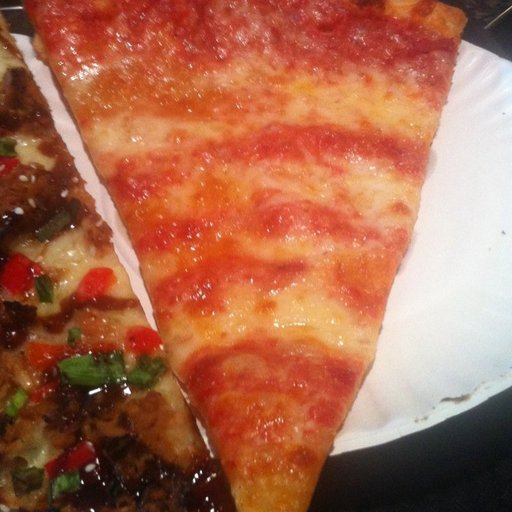

In [15]:
from PIL import Image
img = Image.open("custom_data/pizza_steak_sushi/train/pizza/928670.jpg")
img

#### Setup train and testing paths

In [16]:

train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('custom_data/pizza_steak_sushi/train'),
 PosixPath('custom_data/pizza_steak_sushi/test'))

#### Transformation on the data


Transform functions in the PyTorch library simplify the application of various data enhancement/manipulation techniques 
to your input data. These functions enable you to apply multiple changes simultaneously.

In [18]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [19]:
# Write transform for image
data_transform = transforms.Compose([
    # Resize the images to 64x64
    transforms.Resize(size=(64, 64)),
    # Flip the images randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5), # p = probability of flip, 0.5 = 50% chance
    # Turn the image into a torch.Tensor
    transforms.ToTensor() # this also converts all pixel values from 0 to 255 to be between 0.0 and 1.0 
])

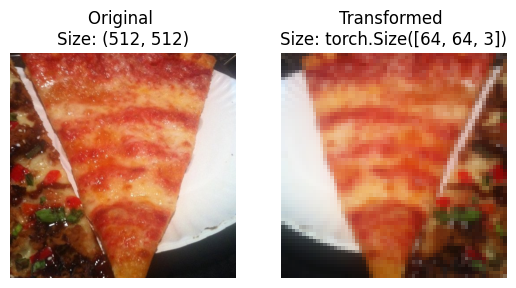

In [20]:
with Image.open("custom_data/pizza_steak_sushi/train/pizza/928670.jpg") as f:
    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(f) 
    ax[0].set_title(f"Original \nSize: {f.size}")
    ax[0].axis("off")

    transformed_image = data_transform(f).permute(1, 2, 0) 
    ax[1].imshow(transformed_image) 
    ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
    ax[1].axis("off")

#### Loading Image Data Using ImageFolder

`ImageFolder` is a generic data loader where images are expected to be organized into separate directories,
each corresponding to a different class.

In [21]:
# Use ImageFolder to create dataset(s)
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir, # target folder of images
                                  transform=data_transform, # transforms to perform on data (images)
                                  target_transform=None) # transforms to perform on labels (if necessary)

test_data = datasets.ImageFolder(root=test_dir, 
                                 transform=data_transform)

print(f"Train data:\n{train_data}\nTest data:\n{test_data}")

Train data:
Dataset ImageFolder
    Number of datapoints: 225
    Root location: custom_data/pizza_steak_sushi/train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 75
    Root location: custom_data/pizza_steak_sushi/test
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )


In [22]:
# Get class names as a list
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [23]:
# Can also get class names as a dict
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [24]:
# Check the lengths
len(train_data), len(test_data)

(225, 75)

#### DataLoader


In PyTorch, `DataLoader` is a built-in class that offers an efficient and flexible method for loading 
data into a model for training or inference. It is especially beneficial for managing large datasets that 
may not fit into memory and for carrying out data augmentation and preprocessing. 
Data loader combines a dataset and a sampler, and provides an iterable over the given dataset.

In [25]:
# Turn train and test Datasets into DataLoaders
from torch.utils.data import DataLoader
train_dataloader = DataLoader(dataset=train_data, 
                              batch_size=8, # how many samples per batch?
                              num_workers=1, # how many subprocesses to use for data loading? (higher = more)
                              shuffle=True) # shuffle the data?

test_dataloader = DataLoader(dataset=test_data, 
                             batch_size=8, 
                             num_workers=1, 
                             shuffle=False) # don't usually need to shuffle testing data

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x1501b0682fd0>,
 <torch.utils.data.dataloader.DataLoader at 0x1501b65ccf90>)

In [26]:
img, label = next(iter(train_dataloader))

print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([8, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([8])


In [27]:
type(img)

torch.Tensor

#### Custom DataLoader

In [29]:
datapath = os.path.expandvars('/scratch/vp91/$USER/intro-to-pytorch/data/pima-indians-diabetes.data.csv')

# Define the custom Dataset class
column_names = [
    'Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness',
    'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'
]

# Define the custom Dataset class
class PimaDataset(Dataset):
    def __init__(self, csv_file):
        # Load the CSV file without header and assign column names
        self.data = pd.read_csv(csv_file, header=None, names=column_names)
        self.features = self.data.drop('Outcome', axis=1).values
        self.labels = self.data['Outcome'].values
        
        # Convert to PyTorch tensors
        self.features_tensor = torch.tensor(self.features, dtype=torch.float32)
        self.labels_tensor = torch.tensor(self.labels, dtype=torch.long)
        
        # Calculate mean and std
        self.mean = self.features_tensor.mean(dim=0)
        self.std = self.features_tensor.std(dim=0)
        
        # Normalize the features
        self.features_tensor = (self.features_tensor - self.mean) / self.std

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        feature = self.features_tensor[idx]
        label = self.labels_tensor[idx]
        return feature, label

In [30]:
dataset = PimaDataset(datapath)
batch_size = 32
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [31]:
features, outcomes = next(iter(data_loader))

print(f"Image shape: {features.shape} -> [batch_size, inputs_features]")
print(f"Label shape: {outcomes.shape}")

Image shape: torch.Size([32, 8]) -> [batch_size, inputs_features]
Label shape: torch.Size([32])


### Exercise

Use ChatGPT or any other LLMs to create a custom dataloader class for the `pizza_steak_sushi` dataset.

Example query - 

I have a dataset called pizza_steak_sushi. The dataset contains three classes of images - pizza, steak and sushi.

When downloaded the dataset is divided into two directories - training and testing. The training directory is divided into three other directories, one for each images classes - pizza, steak and sushi. The training directory is also divided into three other directories, one for each images classes - pizza, steak and sushi.

How would you write a custom dataloader class for this? Explain the code generated.
